# NETFLIX 
Etude des films et séries disponibles sur Netflix by Aurélie RAOUL

In [1]:
# imports
from builtins import set
from time import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

In [2]:
verbose = False

## 1. Lecture du fichier

In [3]:
# ---------------------------------------------------------------------------------------------
#                               Chargement du fichier
# ---------------------------------------------------------------------------------------------
# Lecture du fichier :
print("Chargement des données....")
df = pd.read_csv('C:\\Users\\User\\Documents\\workspace-simplon\\mois-01\\semaine4-Simplon\\netflix_titles.csv', sep=',')
print("Chargement des données........ END")

Chargement des données....
Chargement des données........ END


In [77]:
# ---------------------------------------------------------------------------------------------
#                               PREPARATION DES DONNEES
# ---------------------------------------------------------------------------------------------
#                                     Dimensions

In [4]:
def get_nb_of_type(df, type, verbose=False):
    """
    Retourne le nombre d'éléments du type demandé en paramètre
    :param df: DataFrame
    :param type : String - type recherché
    :param verbose : Boolean - True pour mode debug
    :return: le nombre d'éléments du type demandé en paramètre
    """
    t0 = time()
    nb_type = 0
    types_count = df["type"].value_counts()
    for t,v in types_count.items():
        if t == type:
            nb_type = v
            break
    t1 = time() - t0
    print("get_nb_of_type in {0:.3f} secondes................... END".format(t1))
    return nb_type

In [5]:
# ---------------------------------------------------------------------------------------------
#                               PREPARATION DES DONNEES
# ---------------------------------------------------------------------------------------------
#                               Corrections des types
def cleanType(df, verbose=False):
    """
    Nettoie et Transforme rating en catégorie
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame - a new clean DataFrame
    """
    t0 = time()
    print("cleanType ....")
    df = df.copy()

    # Traitement du type
    df["type"] = df["type"].astype('category')

    # Traitement du rating
    if verbose: print("rating : ", df["rating"].unique())
    # Il y a un décalage pour certaines notes, donc il faut les corriger avant de changer le type
    for rating in df["rating"].unique():
        if " min" in str(rating):
            # Il faut corriger
            df.loc[df["rating"] == rating, 'duration'] = rating
            df.loc[df["rating"] == rating, 'rating'] = np.nan
    if verbose: print("rating : ", df["rating"].unique())
    # Conversion des notes en catégorie
    df["rating"] = df["rating"].astype('category')

    # Traitement de la date
    df["date_added"] = pd.to_datetime(df['date_added'])

    # Traitement de la duration
    df["duration time"] = df["duration"].str.replace(' min','')
    df["duration time"] = df["duration time"].str.replace(' Seasons', '')
    df["duration time"] = df["duration time"].str.replace(' Season', '')
    if verbose:
        print(df[["duration","duration time"]])
        print(df.dtypes)
    df["duration time"] = pd.to_numeric(df["duration time"])

    # Traitement des pays
    df["country"] = df["country"].str.replace('West Germany', 'Germany')
    df["country"] = df["country"].str.replace('East Germany', 'Germany')
    df["country"] = df["country"].str.replace('Soviet Union', 'Russian Federation')
    df["country"] = df["country"].str.replace('Vatican City', 'Holy See')

    # Traitement de l'année
    if verbose:
        print(df["release_year"].unique())
    for year in df["release_year"].unique():
        df.loc[df["release_year"] == year, "annee"] = datetime(year=year, month=1, day=1)

    if verbose: print(df.dtypes)
    t1 = time() - t0
    print("cleanType in {0:.3f} secondes................... END".format(t1))
    return df

In [6]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("|             Corrections des types            |")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Correction des types
print(df.dtypes)
df = cleanType(df, verbose)
print(df.dtypes)
print(df.describe())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
|             Corrections des types            |
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object
cleanType ....
cleanType in 1.403 secondes................... END
show_id                  object
type                   category
title                    object
director                 object
cast                     object
country                  object
date_added       datetime64[ns]
release_year              int64
rating                 category
duration                 object
listed_in                object
description              object
duration time             int64
annee            datetime64[ns]
dtype: object
       release_year  duration time


### VERSION 2

In [7]:
# ---------------------------------------------------------------------------------------------
#                               QUESTIONS - VERSION 2
# ---------------------------------------------------------------------------------------------
def process_country_version2(df, country, verbose=False):
    """
    Créé une copie du DataFrame, y ajoute une colonne pour le pays souhaité avec un boolean si le contenu vient de ce pays = True
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame - a new DataFrame avec la colonne pour le pays
    """
    t0 = time()
    df_copy = df.copy()
    df_country = df_copy["country"].str.split(",", n=0, expand=True)
    if verbose:
        print(df_country.shape)
        print(df_country.columns)
    nb_col = df_country.shape[1]
    df_country[country] = df_country[0].str.strip() == country
    if verbose:
        print(df_country[country])
        print(df_country.columns)
        print(df_country[country].unique())

    for i in range(1, nb_col):
        df_country[i] = df_country[i].str.strip() == country
        df_country[country] = df_country[country] | df_country[i]

    pays = df_country[country]
    df_copy[country] =pays

    nb_total = df_copy[country].value_counts()[True]
    select = df_copy[df_copy["type"] == "Movie"].index.intersection(df_copy[df_copy[country] == True].index)
    nb_films = len(select)
    select = df_copy[df_copy["type"] == "TV Show"].index.intersection(df_copy[df_copy[country] == True].index)
    nb_series = len(select)
    print(country, "nb_total :", nb_total, " - nb_films :", nb_films, " - nb_series :", nb_series)
    t1 = time() - t0
    print("process_country in {0:.3f} secondes................... END".format(t1))
    return df_copy

# Etude des contenus - VERSION 1
5. Etude des catégories avec le plus de contenu
6. Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
7. Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?

Pour ces 3 questions, un traitement commun est mis sous forme de fonction.

In [16]:
def count_unique_data(df, column_name, cat, verbose=False):
    """
    Compte le nombre de contenu unique pour la donnée reçue dans la colonne reçue
    :param df: DataFrame
    :param column_name : String : nom de la colonne à traiter
    :param cat : String - Valeur à compter
    :param verbose : Boolean - True pour mode debug
    :return: Int - nombre de contenu
    """
    t0 = time()
    df = df.copy()
    serie = df[column_name].str.contains(cat, case=False)
    nb_total = serie.value_counts()[True]
    if verbose:
        t1 = time() - t0
        print("count_unique_data in {0:.3f} secondes................... END".format(t1))
    return nb_total


def get_unique_data(df, column_name, verbose=False):
    """
    Compte le nombre de contenu unique pour la colonne reçue et revoi le
    :param df: DataFrame
    :param column_name : String : nom de la colonne à traiter
    :param verbose : Boolean - True pour mode debug
    :return: dic{<data_value>:<data_count>}, dic{<data_count>:[<data_values>]}, max int
    """
    t0 = time()
    df = df.copy()
    categories_list = {}
    categories_by_size = {}
    max = 0
    if verbose: print(column_name, " : ", df[column_name].unique())
    for cats_str in df[column_name].unique():
        if cats_str is None or cats_str == np.nan or type(cats_str) != str:
            continue
        cats = cats_str.split(",")
        for cat in cats:
            cat = cat.strip()
            if len(cat) > 0 and cat not in categories_list:
                # comptage du nombre d'élément par catégorie
                nb = count_unique_data(df, column_name, cat, False)
                categories_list[cat] = nb
                if not categories_by_size.get(nb, False):
                    categories_by_size[nb] = []
                categories_by_size[nb].append(cat)
                if verbose:
                    print(nb," : " , cat)
                if nb > max:
                    max = nb
    t1 = time() - t0
    print("get_unique_data in {0:.3f} secondes................... END".format(t1))
    return categories_list, categories_by_size, max


def print_dic_by_size(dico, limit=5, verbose=False):
    """
    Affiche le dictionnaire par ordre décroissant jusqu'à la limite ou la taille du dico
    :param dico: {dictionnaire(key=int, value} : dictionnaire à afficher
    :param limit: int = nombre d'éléments à afficher (si verbose = True, affiche tout le dictionnaire)
    :param verbose : Boolean - True pour mode debug
    :return: None
    """
    keys = sorted(dico.keys(), reverse=True)
    i = limit
    if verbose:
        i = len(keys)
    for k in keys:
        print(k, " pour ", dico[k])
        i -= 1
        if i == 0:
            break

# Etude des contenus - VERSION 2
5. Etude des catégories avec le plus de contenu
6. Quels directeurs ont produit le plus de films/séries disponibles sur Netflix ?
7. Est-ce que Jan Suter travaille souvent avec les mêmes acteurs ?

Pour ces 3 questions, un traitement commun est mis sous forme de fonction.

In [9]:
def get_unique_data_version(df, column_name, verbose=False):
    """
    Compte le nombre de contenu unique pour la colonne reçue et revoi le
    :param df: DataFrame
    :param column_name : String : nom de la colonne à traiter
    :param verbose : Boolean - True pour mode debug
    :return: dic{<data_value>:<data_count>}, dic{<data_count>:[<data_values>]}, max int
    """
    t0 = time()
    df = df.copy()
    df_data = df[column_name].str.split(",", n=0, expand=True)
    # df_data.to_csv("netflix_categories_dataframe.csv")
    set_liste_data = set()
    if verbose:
        print(df_data.shape)
        print(df_data.columns)
    nb_col = df_data.shape[1]
    # Construction de la liste de données uniques
    for i in range(nb_col):
        set_liste_data = set_liste_data | set(df_data[i].str.strip())

    if verbose:
        print(len(set_liste_data))
        print(set_liste_data)

    data_list = {}
    data_by_size = {}
    max = 0

    for columnName in df_data.columns:
        grp = df_data.groupby(columnName)[columnName].value_counts()
        if verbose:
            print(grp)
        for k,value in grp.items():
            cat = k[1].strip()
            nb = data_list.get(cat, 0) + value
            data_list[cat] = nb

    for cat,nb in data_list.items():
        if not data_by_size.get(nb, False):
            data_by_size[nb] = []
        data_by_size[nb].append(cat)
        if verbose:
            print(nb," : " , cat)
        if nb > max:
            max = nb

    t1 = time() - t0
    print("get_unique_data_version in {0:.3f} secondes................... END".format(t1))
    return data_list, data_by_size, max


-----------------------------------------------------------------------------------------------------------------
# Graphiques    
-----------------------------------------------------------------------------------------------------------------

Pour les graphiques, quelques fonctions et variables globales

In [66]:
# ---------------------------------------------------------------------------------------------
#                               Variables globales
# ---------------------------------------------------------------------------------------------
# Propriétés utilisées pour les graphiques
colorsPaletteSeaborn = ["deep", "muted", "bright", "pastel", "dark", "colorblind"]
colors = ["b", "g", "r", "c", "m", "y", "k"]

# ---------------------------------------------------------------------------------------------
#                               Functions pour les graphiques
# ---------------------------------------------------------------------------------------------

def getAColorsPaletteSeaborn():
    c = sample(colorsPaletteSeaborn, 1)
    return c[0]


def displayBarGraphSeabornOneSerie(df, xName, title, verbose=False, show=True, isY=False):
    colors = sns.color_palette(getAColorsPaletteSeaborn())
    if not isY:
        g = sns.barplot(x=df[xName].index,y=df[xName], palette=colors)
        g.set_ylabel("NB " + xName)
        g.set_xlabel(xName + " Index")
    else:
        g = sns.barplot(x=df[xName], y=df[xName].index, palette=colors)
        g.set_xlabel("NB " + xName)
        g.set_ylabel(xName + " Index")
    plt.title(title)
    if show: plt.show(block=False)
        
        
def getAColor():
    c = sample(colors, 1)
    return c[0]

## 8. Représenter les 10 pays qui ont produits le plus de contenus disponibles sur Netflix, avec le nombre de contenus par pays

Construction de la liste de valeurs par pays

In [11]:
# ---------------------------------------------------------------------------------------------
#                               Variables globales
# ---------------------------------------------------------------------------------------------
# Correction des pays qui sont en erreur dans la librairie
lat_long = {('IT','EU'):(41.871940, 12.567380),         # Italie
            ('JP','AS'): (34.886306, 134.379711),       # ('JP', 'AS') Japan nan
            ('CZ','EU'): (49.817492, 15.472962), 	    # ('CZ', 'EU') Czech Republic nan
            ('VE','SA'): (6.423750, -66.589730),		# ('VE', 'SA') Venezuela nan
            ('NP','AS'): (28.394857, 84.124008),		# ('NP', 'AS') Nepal nan
            ('SY','AS'): (34.802075, 38.996815), 		# ('SY', 'AS') Syria nan
            ('IE','EU'): (53.412910, -8.243890),  		# ('IE', 'EU') Ireland nan
            ('UY','SA'): (-32.522779, -55.765835),   	# ('UY', 'SA') Uruguay nan
            ('KY','NA'): (19.313300, -81.254600), 		# ('KY', 'NA') Cayman Islands nan
            ('JO','AS'): (30.585164, 36.238414), 		# ('JO', 'AS') Jordan nan
            ('ZW','AF'): (-19.015438, 29.154857), 		# ('ZW', 'AF') Zimbabwe nan
            ('FI','EU'): (61.924110, 25.748151),		# ('FI', 'EU') Finland nan
            ('MW','AF'): (-13.254308, 34.301525),  		# ('MW', 'AF') Malawi nan
            ('PY','SA'): (-23.442503, -58.443832), 		# ('PY', 'SA') Paraguay nan
            ('UA','EU'): (44.874119, 33.151245), 		# ('UA', 'EU') Ukraine nan
            ('EC','SA'): (-1.831239, -78.183406),		# ('EC', 'SA') Ecuador nan
            ('AM','AS'): (40.069099, 45.038189), 		# ('AM', 'AS') Armenia nan
            ('LK','AS'): (7.873592, 80.773137),			# ('LK', 'AS') Sri Lanka nan
            ('PR','NA'): (18.220833, -66.590149),		# Puerto Rico
            ('GB','EU'): (52.3555177, -1.1743197),      # United Kingdom
            ('UG','AF'): (1.373333, 32.290275)			# ('UG', 'AF') Uganda nan
            }

In [12]:
# ---------------------------------------------------------------------------------------------
#                          Functions pour les données géographiques
# ---------------------------------------------------------------------------------------------

# 1. Conversion to Alpha 2 codes and Continents
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown'
        if col == 'United Kingdom':
            cn_a2_code = 'GB'
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown'
        if col == 'United Kingdom':
            cn_continent = 'EU'
    return (cn_a2_code, cn_continent)


def geolocate(country, geolocator):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return lat_long.get(country, np.nan)

In [13]:
# ---------------------------------------------------------------------------------------------
#                               Préparation des données
# ---------------------------------------------------------------------------------------------
def countries_prepare_data(df, verbose=False, version=1):
    """
    Ajoute les données manquantes et corrige les types
    :param df: DataFrame
    :param verbose : Boolean - True pour mode debug
    :return: DataFrame
    """
    t0 = time()
    dfc = df.copy()
    
    # Construction de la liste des catégories
    if version == 2:
        countries_list, countries_by_size, max_dir = get_unique_data_version(dfc.copy(), "country", verbose)
    else:
        countries_list, countries_by_size, max_dir = get_unique_data(dfc.copy(), "country", verbose)
    
    # Conversion de notre liste en DataFrame
    countries_df = pd.DataFrame.from_dict(countries_list, orient="index", columns=["nb_contenus"])
    if verbose: print(countries_df)

    # Il faut ajouter codes, country, continent,
    countries_df["Country"] = ""
    countries_df["Continent"] = ""
    countries_df["Latitude"] = ""
    countries_df["Longitude"] = ""
    geolocator = Nominatim(user_agent="catuserbot")
    for c, row in countries_df.iterrows():
        res = get_continent(c)
        if res[0] != 'Unknown' and res[1] != 'Unknown':
            countries_df.loc[c, 'Country'] = res[0]
            countries_df.loc[c, 'Continent'] = res[1]

            geoloc = geolocate(res, geolocator)
            if geoloc != np.nan:
                try:
                    countries_df.loc[c, "Latitude"] = geoloc[0]
                    countries_df.loc[c, "Longitude"] = geoloc[1]
                except TypeError:
                    print("TypeError for :", res, c, geoloc)
            else:
                print("Country not found geoloc :", res, c)
        elif res[0] != 'Unknown':
            countries_df.loc[c, 'Country'] = res[0]
        elif res[1] != 'Unknown':
            countries_df.loc[c, 'Continent'] = res[1]
        else:
            if c == 'Holy See':
                countries_df.loc[c, "Latitude"] = 41.902916
                countries_df.loc[c, "Longitude"] = 12.453389
            else:
                print("Country not known :", c)

    if verbose:
        print(countries_df)
        # countries_df.to_csv("countries.csv")

    # Traitement des valeurs manquantes et corrections des types
    if verbose:
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("|     Exploration des valeurs manquantes / correction des types        |")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Compter les valeurs manquantes")
        print(countries_df.shape)
        print(countries_df.isna().sum())
    countries_df = countries_df.dropna(axis=0)
    if verbose:
        print("------")
        print(countries_df.shape)
        print(countries_df.isna().sum())
        print(countries_df.dtypes)
    countries_df["Longitude"] = pd.to_numeric(countries_df["Longitude"])
    countries_df["Latitude"] = pd.to_numeric(countries_df["Latitude"])
    if verbose:
        print(countries_df.dtypes)

    t1 = time() - t0
    print("countries_prepare_data in {0:.3f} secondes................................................... END".format(t1))
    return countries_df, countries_list, countries_by_size


In [18]:
countries_df, countries_list, countries_by_size = countries_prepare_data(df, verbose, 2)
print("Nb country :", len(countries_list))

print("Représenter les 10 pays qui ont produits le plus de contenus disponibles sur Netflix, avec le nombre de contenus par pays?")


get_unique_data_version in 0.348 secondes................... END
Country not known : 
countries_prepare_data in 59.751 secondes................................................... END
Nb country : 121
Représenter les 10 pays qui ont produits le plus de contenus disponibles sur Netflix, avec le nombre de contenus par pays?


In [19]:
# Pour éviter de tout afficher
print_dic_by_size(countries_by_size, 10, verbose)

3690  pour  ['United States']
1046  pour  ['India']
806  pour  ['United Kingdom']
445  pour  ['Canada']
393  pour  ['France']
318  pour  ['Japan']
232  pour  ['Germany', 'Spain']
231  pour  ['South Korea']
169  pour  ['Mexico']
162  pour  ['China']


In [20]:
# Récupération des 10 pays
countries_light = countries_df.sort_values("nb_contenus", ascending=False).head(10)
countries_light

,nb_contenus,Country,Continent,Latitude,Longitude
United States,3690,US,NA,40.643287,-73.794928
India,1046,IN,AS,26.407384,93.255130
United Kingdom,806,GB,EU,51.454989,-2.607279
Canada,445,CA,NA,33.151865,-117.182229
France,393,FR,EU,50.049170,1.417574
Japan,318,JP,AS,34.886306,134.379711
Germany,232,DE,EU,49.932519,1.580598
Spain,232,ES,EU,45.930986,18.935675
South Korea,231,KR,AS,37.454773,126.446132
Mexico,169,MX,NA,18.797382,98.952169


In [21]:
# ---------------------------------------------------------------------------------------------
#                               Préparation des données
# ---------------------------------------------------------------------------------------------
def countries_progress_prepare_data(df, countries_light, verbose=False):
    t0 = time()
    country_prog_df = df.copy()
    countries_light = countries_light.copy()

    # Ajout des années en colonnes du DF countries_light
    # les valeurs étant le nombre de films
    years = country_prog_df["release_year"].unique()
    years = years.tolist()
    # Trie des années par ordre chronologique pour le tableau
    years = sorted(years)
    print(years)
    for year in years:
        countries_light[year] = 0

    # Ajoute une colonne pour le pays concerné avec True or False si le pays a contribué
    # Donc 10 colonnes sont ajoutées au dataset
    for pays_name in countries_light.index:
        country_prog_df = process_country_version2(country_prog_df, pays_name, verbose)
        country_prog_df.loc[country_prog_df[pays_name] == False, pays_name] = np.nan
        if verbose:
            print(country_prog_df.shape)
        # Récupération du nombre par an
        group_year = country_prog_df.groupby("release_year")[pays_name].value_counts()
        # Ajout le total dans le countries_light de chaque année
        for y in group_year.index:
            countries_light.loc[pays_name, y] = group_year[y]

    if verbose:
        print(countries_light.shape)
        print(countries_light.columns)
        print(countries_light.head(10))

    # Inversion des colonnes et des lignes
    countries_light_country_columns = countries_light.transpose()
    if verbose:
        countries_light_country_columns.head(10)
    
    # suppression des colonnes inutiles
    countries_light_country_columns = countries_light_country_columns.drop(
        ['nb_contenus', 'Country', 'Continent', 'Latitude', 'Longitude', 1.0])
    
    countries_light_years_columns = countries_light_country_columns.transpose()
        
    if verbose:
        print(countries_light_years_columns.head(10))
        print(countries_light_years_columns.dtypes)
        print("-----------------------------------")
        print(countries_light_country_columns.head(10))
        print(countries_light_country_columns.dtypes)
        
    # correction des types
    for colname in countries_light_country_columns.columns:
        countries_light_country_columns[colname] = pd.to_numeric(countries_light_country_columns[colname])
    
    for colname in countries_light_years_columns.columns:
        countries_light_years_columns[colname] = pd.to_numeric(countries_light_years_columns[colname])
    
    if verbose:
        print(countries_light_years_columns.dtypes)
        print("-----------------------------------")
        print(countries_light_country_columns.dtypes)
      
    t1 = time() - t0
    print("countries_progress_prepare_data in {0:.3f} secondes................................................... END".format(t1))
    return countries_light, years, countries_light_country_columns, countries_light_years_columns

In [22]:
verbose = False
# 10. Tracer un graphique qui montre l'évolution du nombre de films/séries produits par les 10 pays les plus producteurs de contenus sur Netflix, au fil des ans
countries_light, years, countries_light_country_columns, countries_light_years_columns = countries_progress_prepare_data(df, countries_light, verbose)
countries_light_country_columns.head(10)

[1925, 1942, 1943, 1944, 1945, 1946, 1947, 1954, 1955, 1956, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
United States nb_total : 3690  - nb_films : 2752  - nb_series : 938
process_country in 0.147 secondes................... END
India nb_total : 1046  - nb_films : 962  - nb_series : 84
process_country in 0.100 secondes................... END
United Kingdom nb_total : 806  - nb_films : 534  - nb_series : 272
process_country in 0.147 secondes................... END
Canada nb_total : 445  - nb_films : 319  - nb_series : 126
process_country in 0.116 secondes................... END
France nb_total : 393  - nb_films : 303  - nb_series : 90
process_country i

,United States,India,United Kingdom,Canada,France,Japan,Germany,Spain,South Korea,Mexico
1925,0,0,0,0,0,0,0,0,0,0
1942,2,0,0,0,0,0,0,0,0,0
1943,3,0,0,0,0,0,0,0,0,0
1944,3,0,1,0,0,0,0,0,0,0
1945,4,0,0,0,0,0,0,0,0,0
1946,2,0,0,0,0,0,0,0,0,0
1947,1,0,0,0,0,0,0,0,0,0
1954,1,0,0,0,0,0,0,0,0,0
1955,1,0,0,0,1,0,0,0,0,0
1956,1,0,0,0,0,0,0,0,0,0


In [23]:
countries_light_country_columns.dtypes

United States     int64
India             int64
United Kingdom    int64
Canada            int64
France            int64
Japan             int64
Germany           int64
Spain             int64
South Korea       int64
Mexico            int64
dtype: object

In [24]:
countries_light_years_columns.head(10)

,1925,1942,1943,1944,1945,1946,1947,1954,1955,1956,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
United States,0,2,3,3,4,2,1,1,1,1,...,101,112,138,210,348,442,457,428,384,173
India,0,0,0,0,0,0,0,0,0,0,...,41,58,56,70,80,111,101,93,77,35
United Kingdom,0,0,0,1,0,0,0,0,0,0,...,22,29,46,66,102,101,96,68,68,36
Canada,0,0,0,0,0,0,0,0,0,0,...,16,8,30,36,57,58,67,44,39,12
France,0,0,0,0,0,0,0,0,1,0,...,7,16,23,33,52,40,47,49,26,13
Japan,0,0,0,0,0,0,0,0,0,0,...,7,11,16,16,25,37,49,36,24,15
Germany,0,0,0,0,0,0,0,0,0,0,...,6,7,12,14,30,22,14,14,33,9
Spain,0,0,0,0,0,0,0,0,0,0,...,2,6,3,16,31,33,46,32,31,16
South Korea,0,0,0,0,0,0,0,0,0,0,...,11,6,8,16,36,33,34,27,31,20
Mexico,0,0,0,0,0,0,0,0,0,0,...,3,2,4,9,23,20,25,25,23,13


In [25]:
countries_light_years_columns.dtypes

1925    int64
1942    int64
1943    int64
1944    int64
1945    int64
        ...  
2017    int64
2018    int64
2019    int64
2020    int64
2021    int64
Length: 74, dtype: object

In [26]:
df_origin_more_countries = df.copy()
country_names = []

# df_origin_more_countries["annee"] = "01/01/" + str(df_origin_more_countries["release_year"])
# df_origin_more_countries.loc[annee]["annee"] = "01/01/" + str(annee)
df_origin_more_countries["annee"] = pd.to_datetime(df_origin_more_countries["annee"], dayfirst=True)

print(df_origin_more_countries.shape)
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        country_names.append(country)
        df_origin_more_countries = process_country_version2(df_origin_more_countries, country, False)
        df_origin_more_countries[country] = df_origin_more_countries[country].astype(int)
        # df_origin_more_countries.loc[df_origin_more_countries[country] == 0, country] = np.nan
print(df_origin_more_countries.head(10))
print(df_origin_more_countries.shape)
print(df_origin_more_countries.dtypes)


(8807, 14)
United States nb_total : 3690  - nb_films : 2752  - nb_series : 938
process_country in 0.322 secondes................... END
India nb_total : 1046  - nb_films : 962  - nb_series : 84
process_country in 0.159 secondes................... END
United Kingdom nb_total : 806  - nb_films : 534  - nb_series : 272
process_country in 0.127 secondes................... END
Canada nb_total : 445  - nb_films : 319  - nb_series : 126
process_country in 0.154 secondes................... END
France nb_total : 393  - nb_films : 303  - nb_series : 90
process_country in 0.132 secondes................... END
Japan nb_total : 318  - nb_films : 119  - nb_series : 199
process_country in 0.100 secondes................... END
Germany nb_total : 231  - nb_films : 185  - nb_series : 46
process_country in 0.116 secondes................... END
Spain nb_total : 232  - nb_films : 171  - nb_series : 61
process_country in 0.116 secondes................... END
South Korea nb_total : 231  - nb_films : 61  - nb

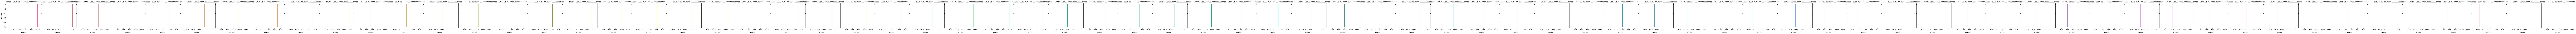

In [27]:
g = sns.FacetGrid(df_origin_more_countries, col='annee', hue='annee')
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        g.map(plt.plot, 'annee', country)
plt.show()

ValueError: setting an array element with a sequence.

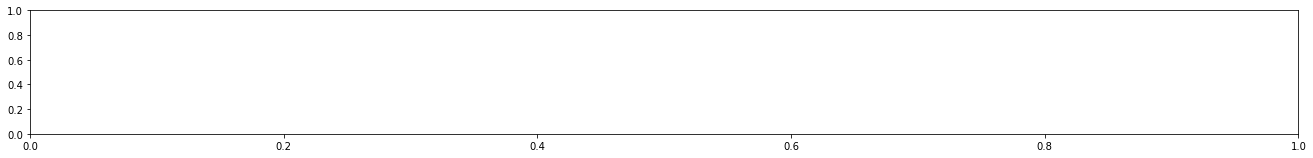

In [116]:
fig = plt.figure(figsize=(50,5))

group = df_origin_more_countries.groupby("annee")

ax = []
i = 1
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        axn = fig.add_subplot(2,2,i)
        # On peut compléter les instances de sous graphiques par leur contenu.
        # Au passage, quelques autres exemples de graphes
        # ax1.hist(randn(100),bins=20,color='k',alpha=0.3)
        # ax2.scatter(np.arange(30),np.arange(30)+3*randn(30))
        # ax3.plot(randn(50).cumsum(),'k--')
        axn.plot(group["annee"], group[country])
        i += 1
        ax.append(axn)
plt.show()

# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)
# ax3 = fig.add_subplot(2,2,3)

# On peut compléter les instances de sous graphiques par leur contenu.
# Au passage, quelques autres exemples de graphes
# ax1.hist(randn(100),bins=20,color='k',alpha=0.3)
# ax2.scatter(np.arange(30),np.arange(30)+3*randn(30))
# ax3.plot(randn(50).cumsum(),'k--')

ValueError: setting an array element with a sequence.

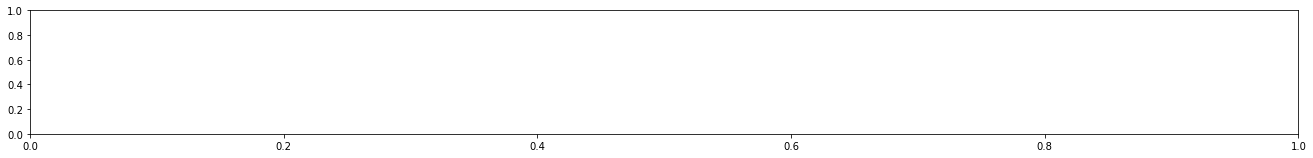

In [116]:
fig = plt.figure(figsize=(50,5))

group = df_origin_more_countries.groupby("annee")

ax = []
i = 1
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        axn = fig.add_subplot(2,2,i)
        # On peut compléter les instances de sous graphiques par leur contenu.
        # Au passage, quelques autres exemples de graphes
        # ax1.hist(randn(100),bins=20,color='k',alpha=0.3)
        # ax2.scatter(np.arange(30),np.arange(30)+3*randn(30))
        # ax3.plot(randn(50).cumsum(),'k--')
        axn.plot(group["annee"], group[country])
        i += 1
        ax.append(axn)
plt.show()

# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)
# ax3 = fig.add_subplot(2,2,3)

# On peut compléter les instances de sous graphiques par leur contenu.
# Au passage, quelques autres exemples de graphes
# ax1.hist(randn(100),bins=20,color='k',alpha=0.3)
# ax2.scatter(np.arange(30),np.arange(30)+3*randn(30))
# ax3.plot(randn(50).cumsum(),'k--')

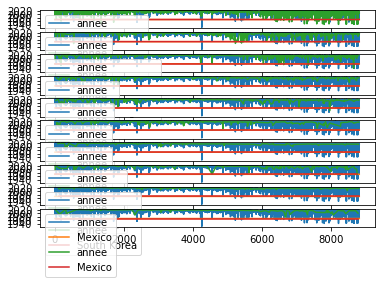

<Figure size 432x288 with 0 Axes>

In [122]:
figure, axes = plt.subplots(len(country_names),1)
i = 0
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        countryGroup = df_origin_more_countries.groupby(country)[["annee", country]]
        countryGroup.plot(ax=axes[i])
        i+= 1

plt.show()
plt.subplots_adjust(wspace=0,hspace=0)

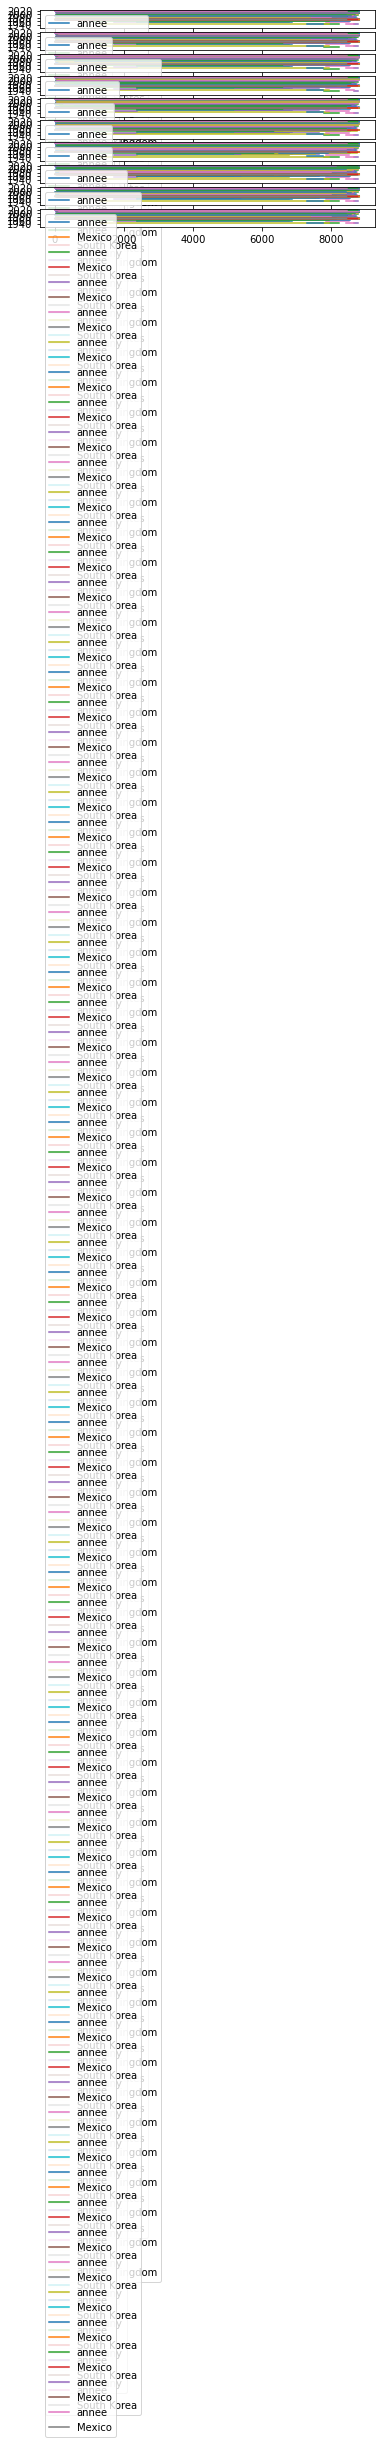

<Figure size 432x288 with 0 Axes>

In [123]:
figure, axes = plt.subplots(len(country_names),1)
i = 0
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        countryGroup = df_origin_more_countries.groupby("annee")[["annee", country]]
        countryGroup.plot(ax=axes[i])
        i+= 1

plt.show()
plt.subplots_adjust(wspace=0,hspace=0)

United States  ---> END
India  ---> END
United Kingdom  ---> END
Canada  ---> END
France  ---> END
Japan  ---> END
Germany  ---> END
Spain  ---> END
South Korea  ---> END
Mexico  ---> END


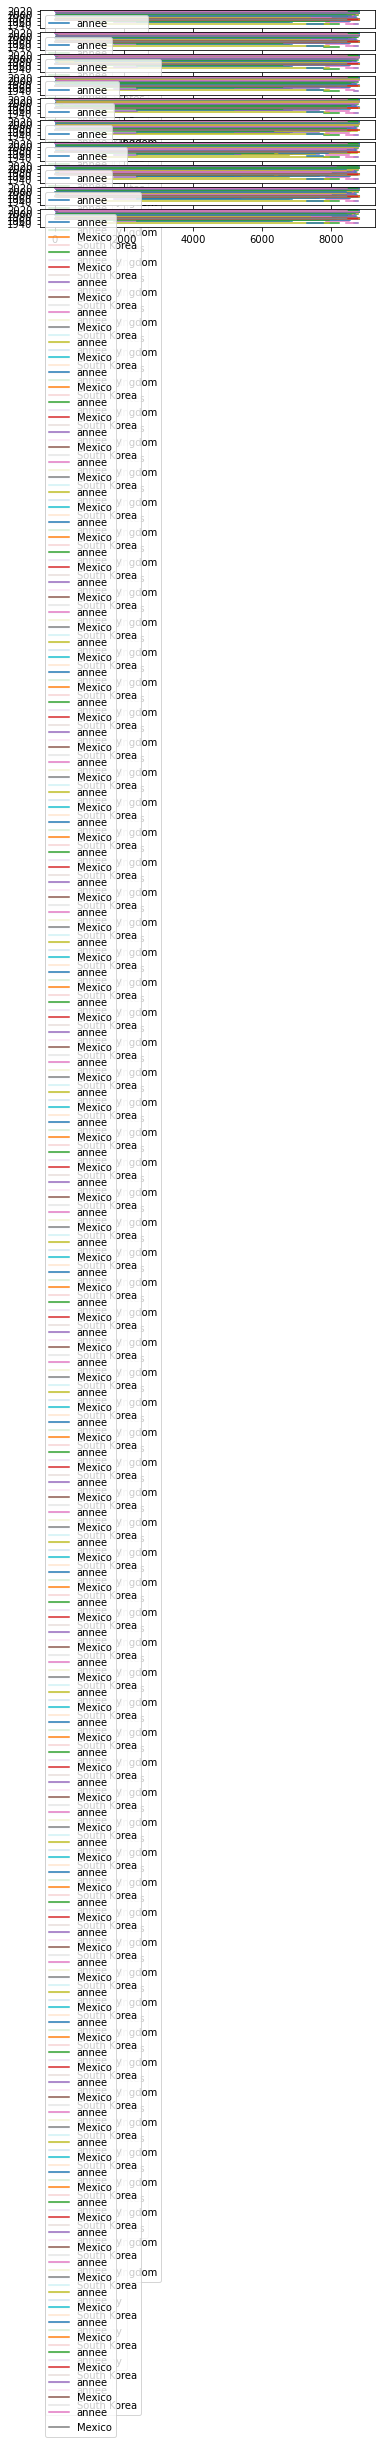

In [30]:
figure, axes = plt.subplots(len(country_names),1)
i = 0

# df3 = pd.DataFrame(np.random.randn(1000, 2), columns=["B", "C"]).cumsum()
# df3["A"] = pd.Series(list(range(len(df))))
# df3.plot(x="A", y="B");

for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        countryGroup = df_origin_more_countries.groupby("annee")[["annee", country]]
        if verbose:
            print(countryGroup.dtypes)
            print(countryGroup.head)
        #print(countryGroup.columns)
        countryGroup.plot(ax=axes[i])
        print(country, " ---> END")
        i+= 1

plt.show()
#plt.subplots_adjust(wspace=0,hspace=0)

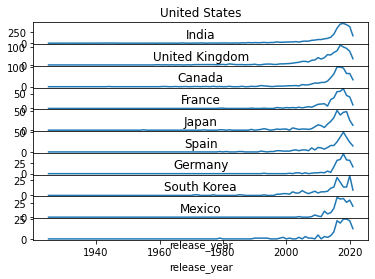

In [164]:
# Define and use a simple function to label the plot in axes coordinates
# SUCCESS !!!!!!!!
figure, axes = plt.subplots(len(country_names),1)
i = 0   
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        countryGroup =  df_origin_more_countries.groupby("release_year")[country].sum()
        countryGroup.plot(ax=axes[i])
        axes[i].set_title(country)
        i+= 1
        
plt.subplots_adjust(wspace=100,hspace=0)

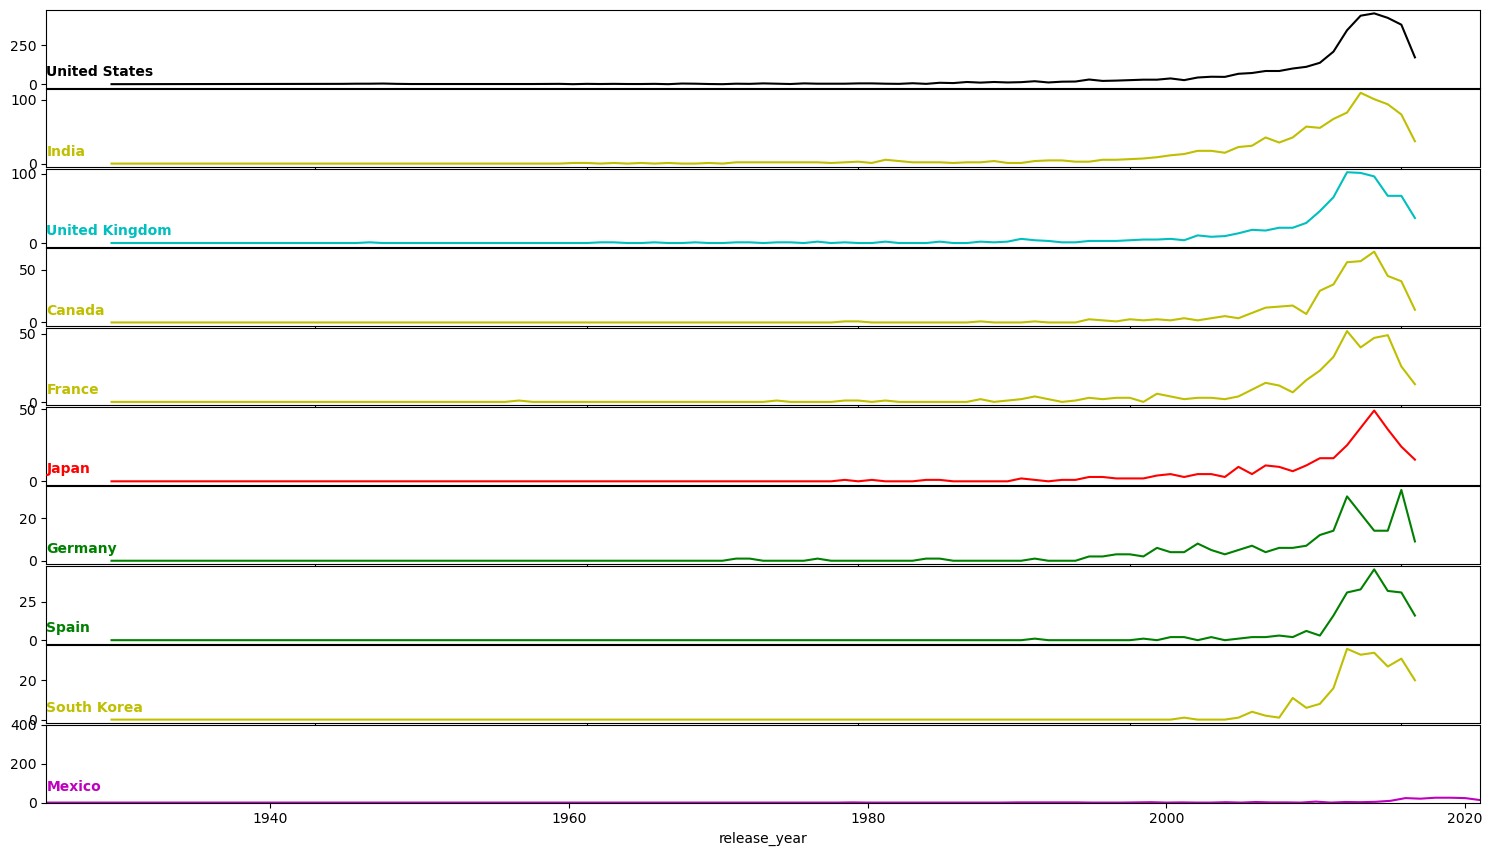

In [68]:
# Define and use a simple function to label the plot in axes coordinates
# SUCCESS !!!!!!!!
figure, axes = plt.subplots(len(country_names),1)
i = 0   

used_colors = []

for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        color = getAColor()
        used_colors.append(color)
        countryGroup =  df_origin_more_countries.groupby("release_year")[country].sum()
        countryGroup.plot(ax=axes[i], color=color)
        axes[i].set_autoscaley_on(False)
        axes[i].text(0, .2, country, fontweight="bold", color=color, ha="left", va="center", transform=axes[i].transAxes)
        i+= 1

figure.set_size_inches(18.5, 10.5, forward=True)
figure.set_dpi(100)
        
plt.xlim([min(years),max(years)])
plt.ylim([0,400])
plt.subplots_adjust(wspace=1000)
plt.subplots_adjust(hspace=.02)

In [ ]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        countryGroup =  df_origin_more_countries.groupby("release_year")[country].sum()
        g = sns.FacetGrid(data=df_origin_more_countries, col="release_year", row=country, palette=pal, aspect=15, height=.5)
        g = g.map(plt.hist, country)
        #plt.subplots_adjust(top=0.9)
        g.fig.suptitle(country)
plt.show()

In [ ]:
from matplotlib import pyplot as plt



# figure, axes = plt.subplots(len(country_names),1)
# i = 0   
# for country in countries_light.index:
#     if country != None and country != np.nan and len(country) > 0:
#         countryGroup =  df_origin_more_countries.groupby("release_year")[country].sum()
#         countryGroup.plot(ax=axes[i])
#         axes[i].set_title(country)
#         i+= 1

# plt.subplots_adjust(wspace=100,hspace=0)


df_origin_more_countries.groupby("release_year").plot(subplots=True, layout=(len(country_names),1), x="release_year", y=country_names)
plt.show()
plt.subplots_adjust(wspace=0,hspace=0)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


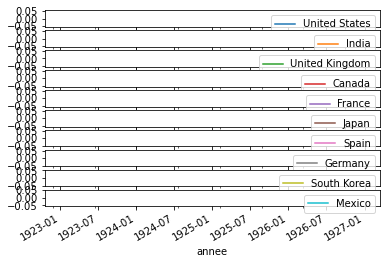

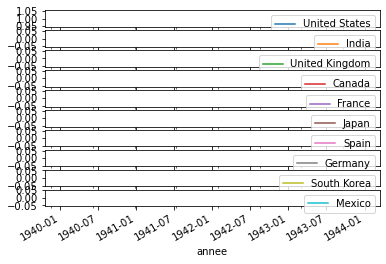

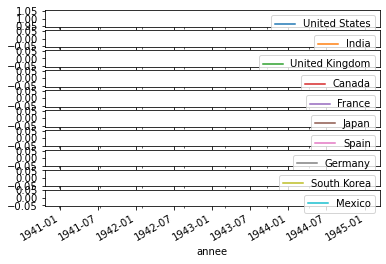

In [ ]:
from matplotlib import pyplot as plt

# df.plot(subplots=True, layout=(1,2))
# fig.add_subplot()

df_origin_more_countries.groupby("annee").plot(subplots=True, layout=(len(country_names),1), x="annee", y=country_names)
#df_origin_more_countries.groupby("annee").plot(subplots=True, layout=(len(country_names),1), x="annee", y=country_names)
plt.show()
plt.subplots_adjust(wspace=0,hspace=0)

# fig,axes = plt.subplots(len(country_names),2021,sharex=True,sharey=True)
# Sharex et sharey portent bien leurs noms : si True, ils indiquent que les sous-graphiques
# ont des axes paramétrés de la même manière
# for j in range(len(country_names)):
    #axes[1,j].hist(country_names["annee"], y=country_names[j],bins=50,color='k',alpha=0.5)
#    axes[j,1].plot(data=df_origin_more_countries, x="annee", y=country_names[j])
    #df_origin_more_countries.plot(x="annee", y=country_names[j])
    #df_origin_more_countries.plot(x="annee", y=country_names)
    #df_origin_more_countries.groupby("annee").plot(x="annee", y=country_names)
# L'objet "axes" est un 2darray, simple à indicer et parcourir avec une boucle
# print(type(axes))

# N'h'ésitez pas à faire varier les paramètres qui vous posent question. Par exemple, à quoi sert alpha ?

# Cette dernière méthode permet de supprimer les espaces entres les sous graphes.

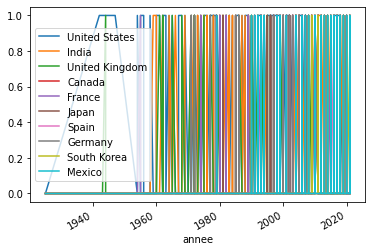

In [103]:
df_origin_more_countries.plot(x="annee", y=country_names)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


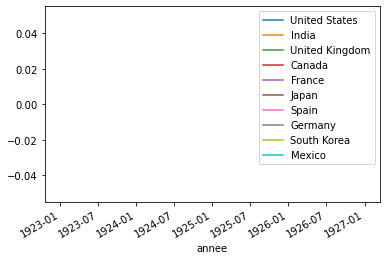

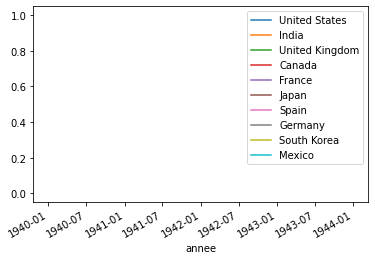

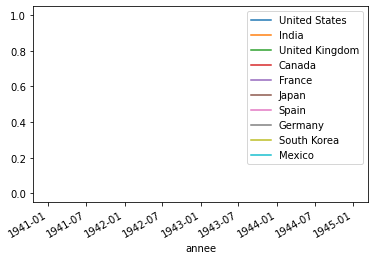

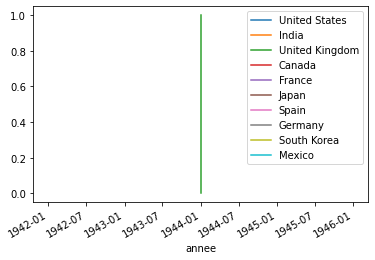

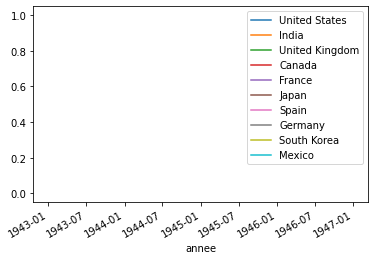

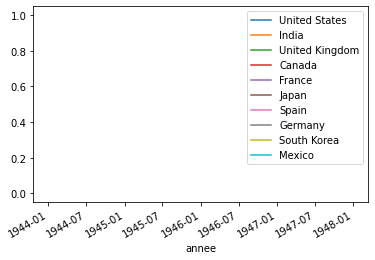

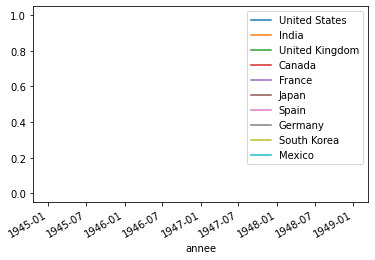

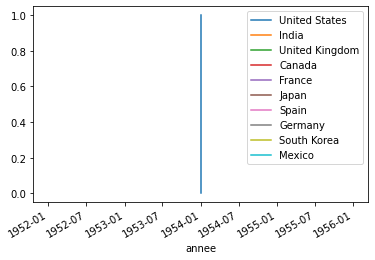

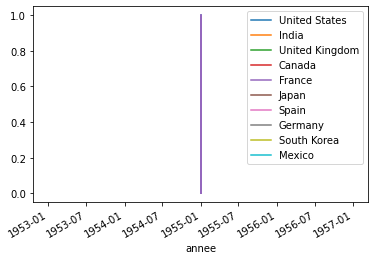

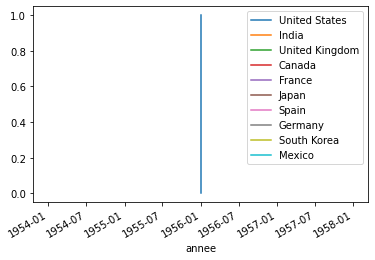

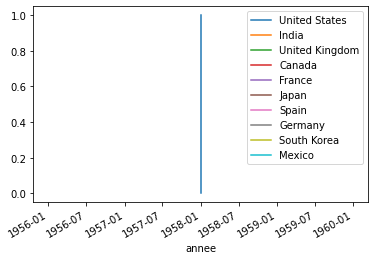

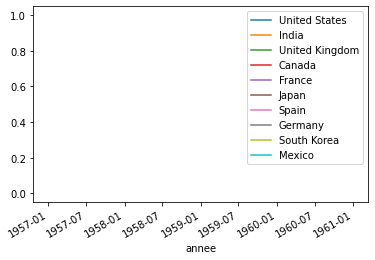

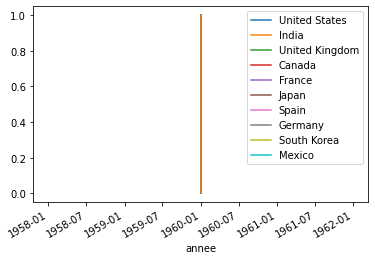

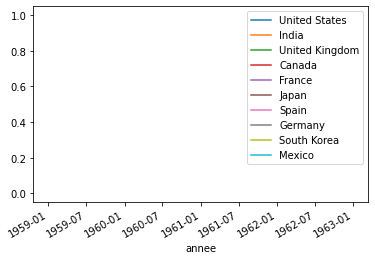

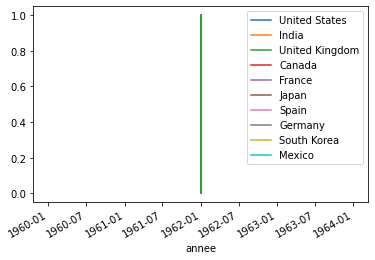

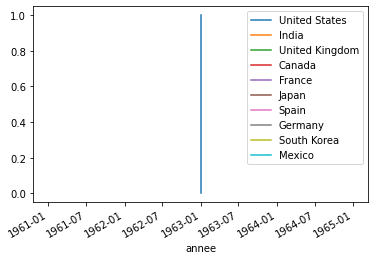

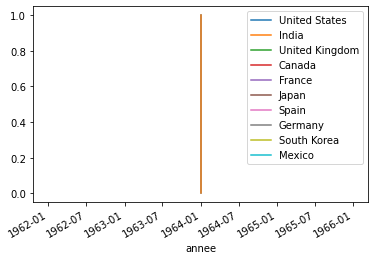

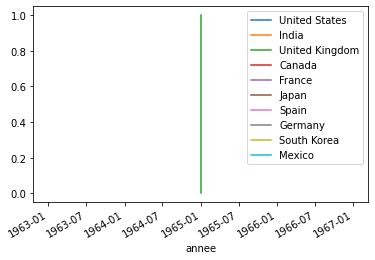

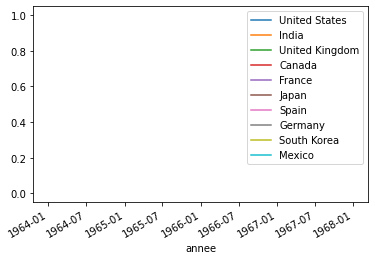

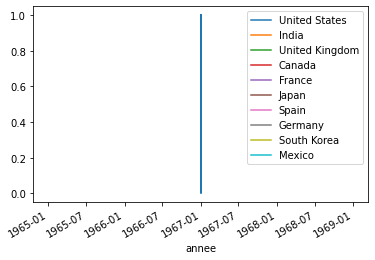

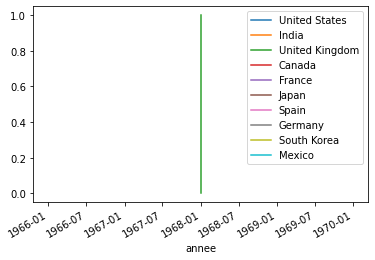

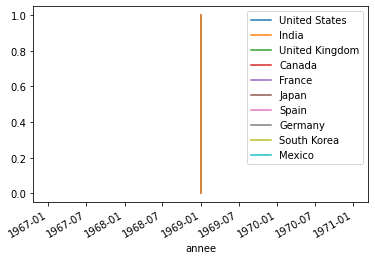

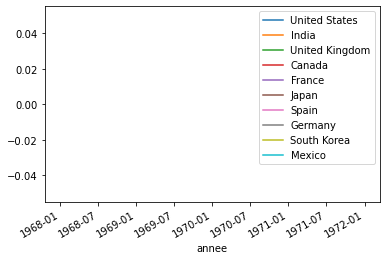

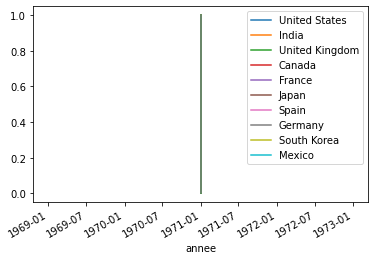

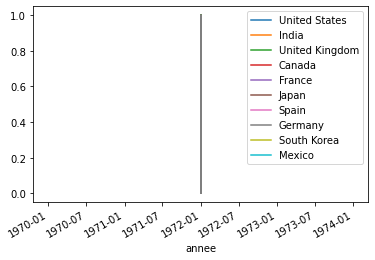

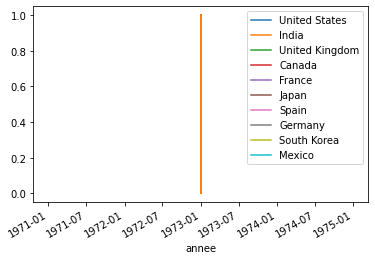

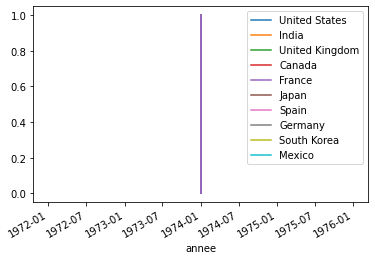

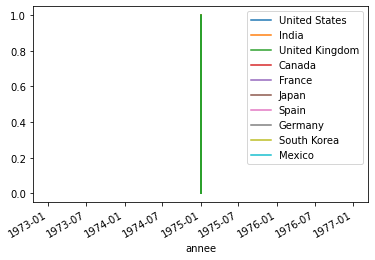

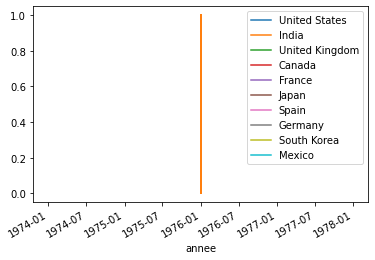

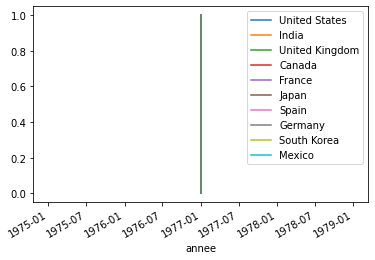

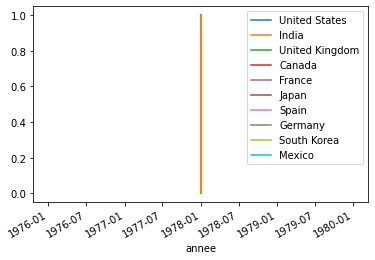

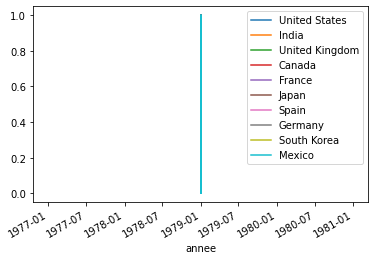

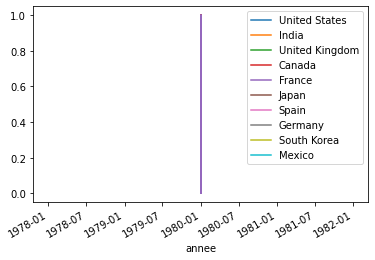

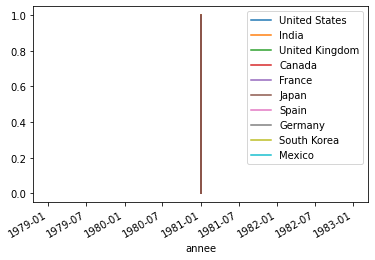

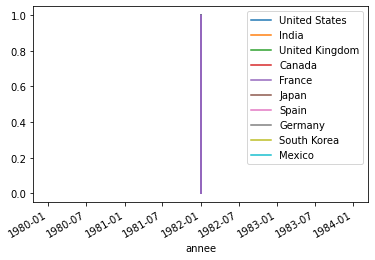

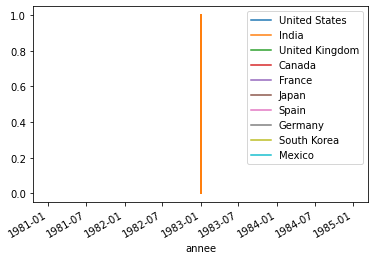

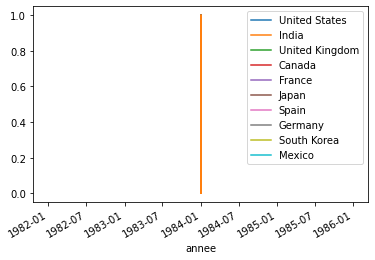

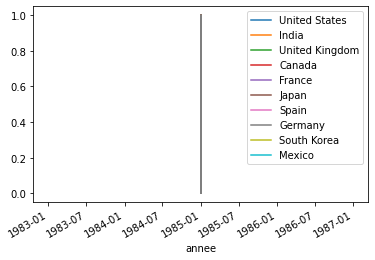

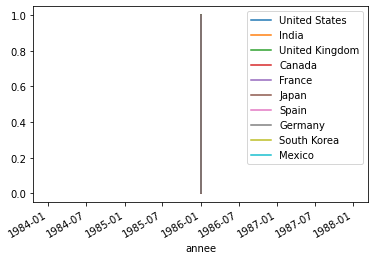

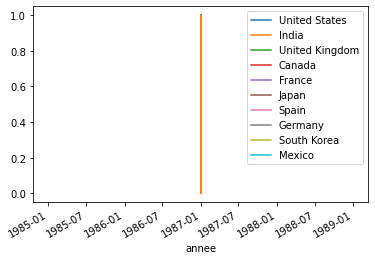

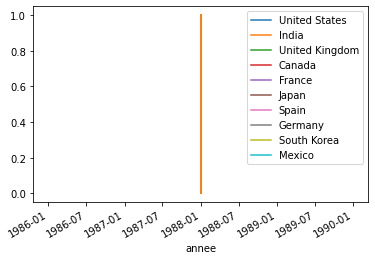

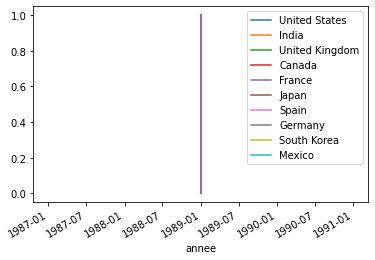

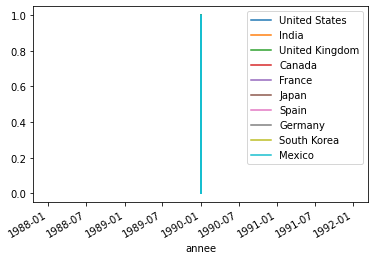

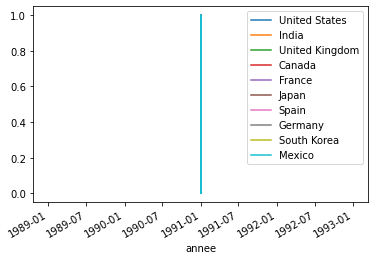

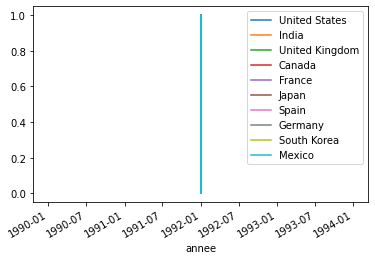

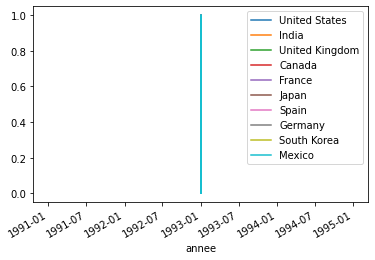

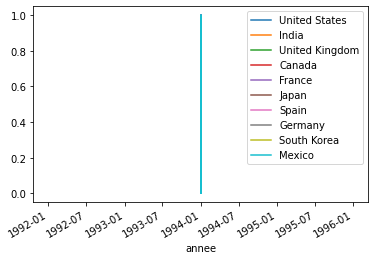

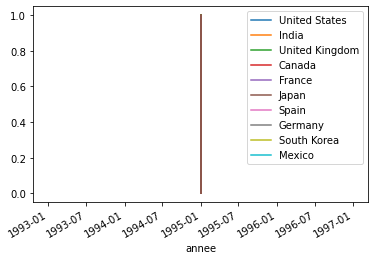

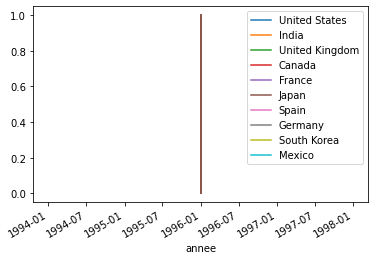

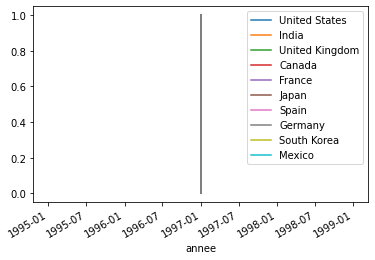

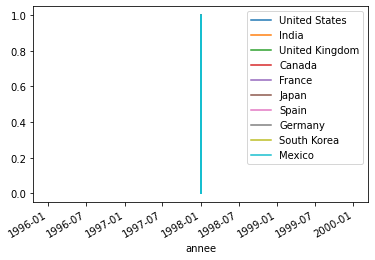

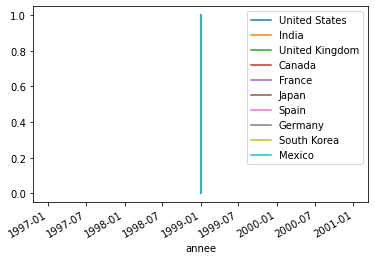

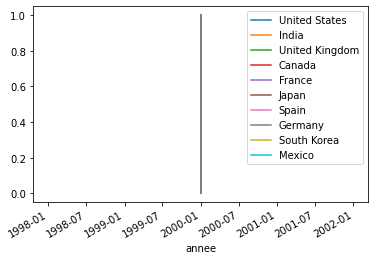

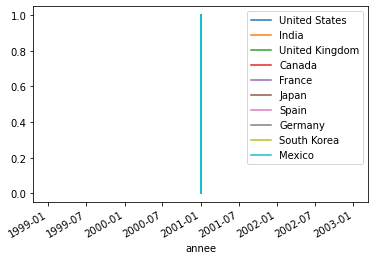

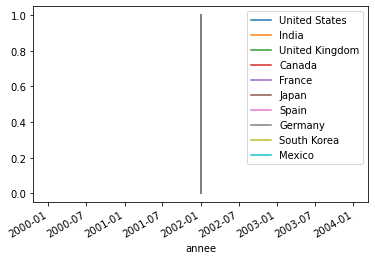

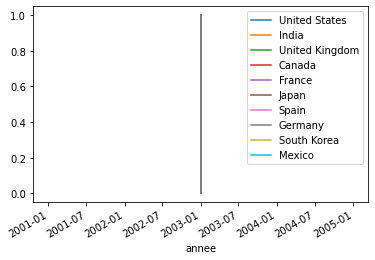

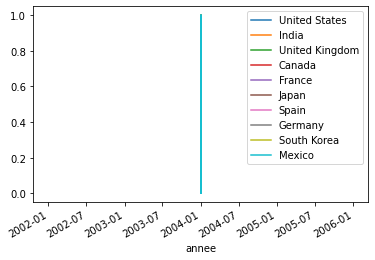

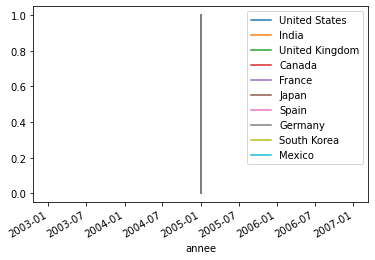

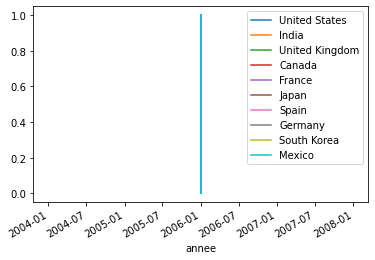

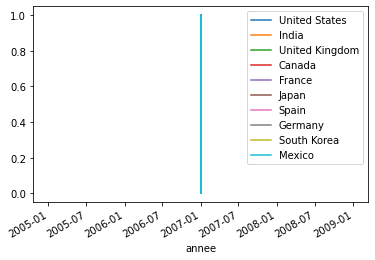

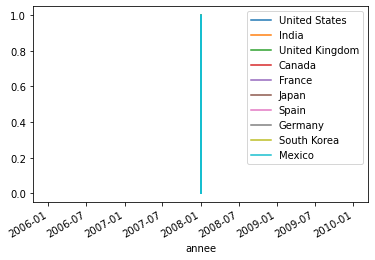

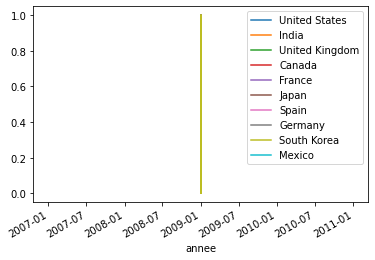

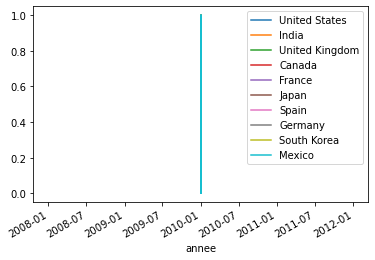

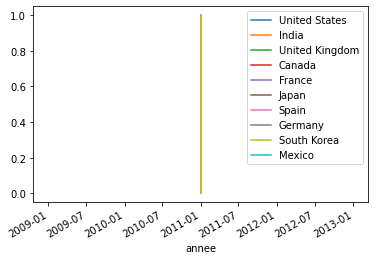

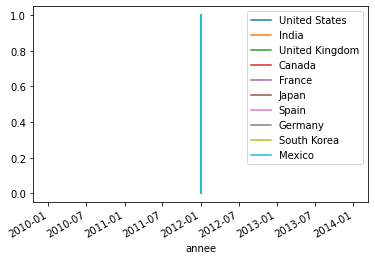

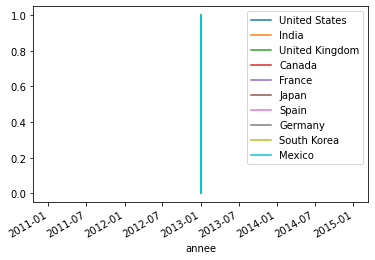

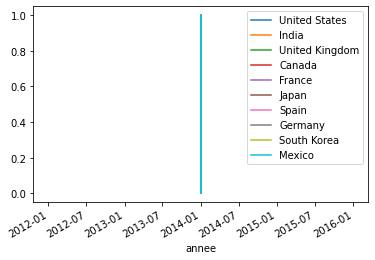

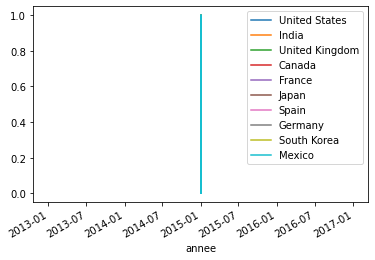

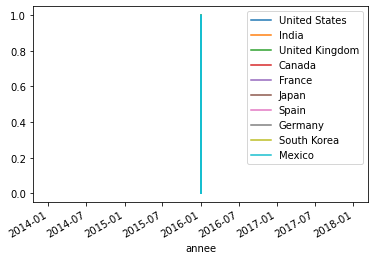

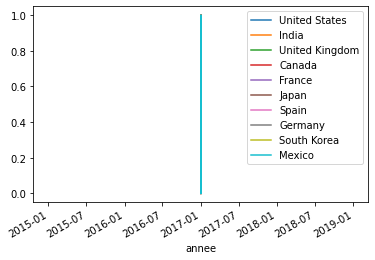

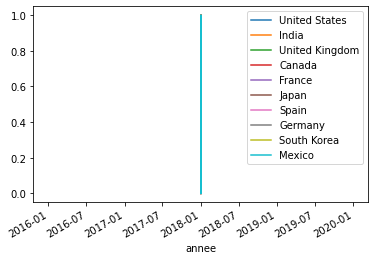

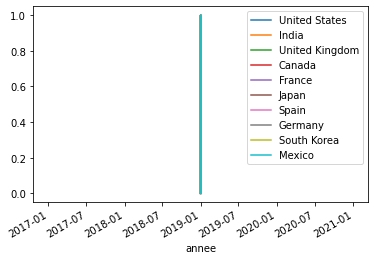

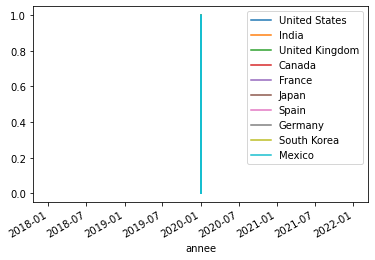

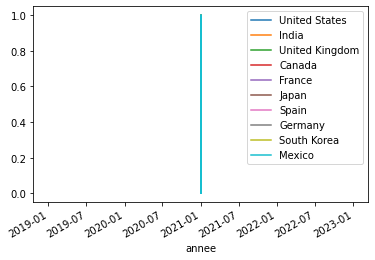

In [111]:
df_origin_more_countries.groupby("annee").plot(x="annee", y=country_names)
plt.show()

In [ ]:
grouped = df_origin_more_countries.groupby("annee")

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)

ax.legend()
plt.show()

In [109]:
df_evolution = df_origin_more_countries.groupby("annee").value_counts()
df_evolution.plot(x="annee", y=country_names)
plt.show()

AttributeError: 'DataFrameGroupBy' object has no attribute 'value_counts'

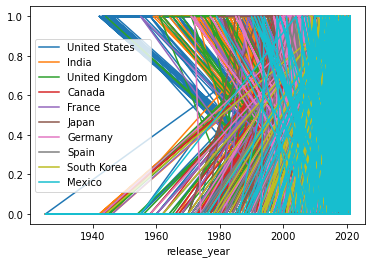

In [65]:
df_origin_more_countries.plot(x="release_year", y=country_names)
plt.show()

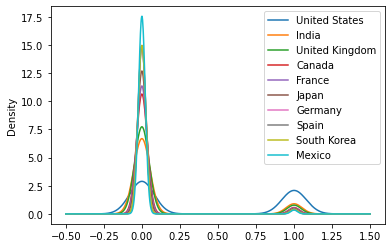

In [66]:
df_origin_more_countries.plot(x="release_year", y=country_names, kind="kde")
plt.show()

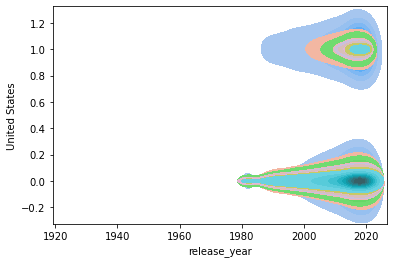

In [41]:
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        sns.kdeplot(x=df_origin_more_countries["release_year"], y=df_origin_more_countries[country], shade=True)
        plt.show()

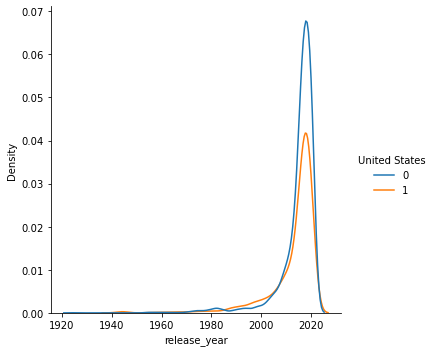

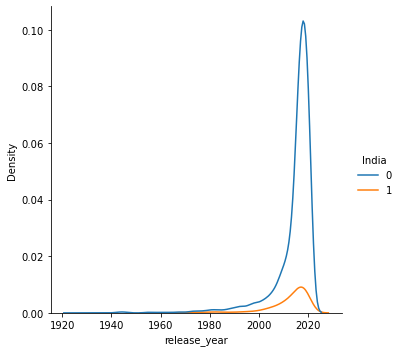

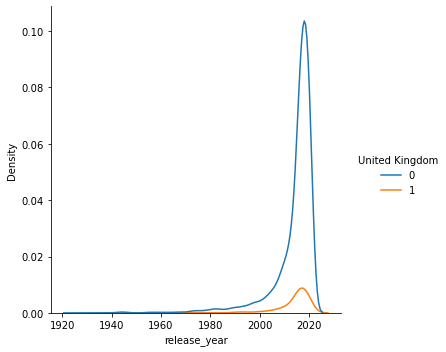

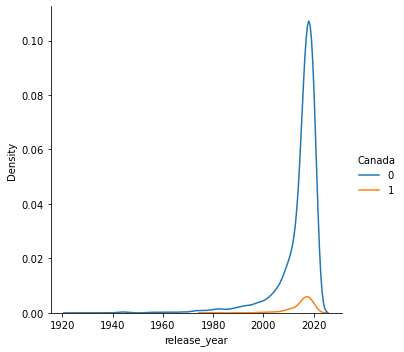

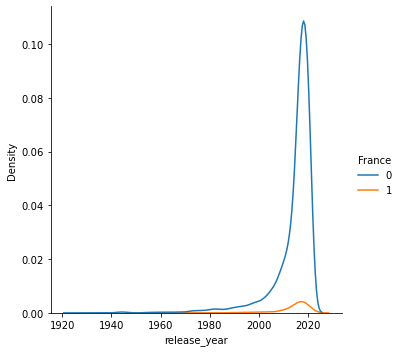

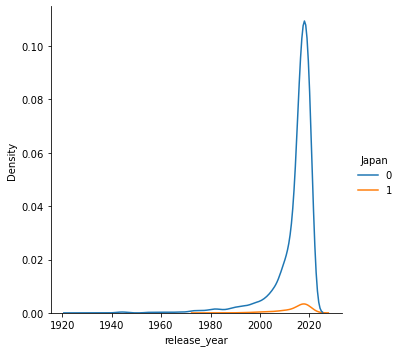

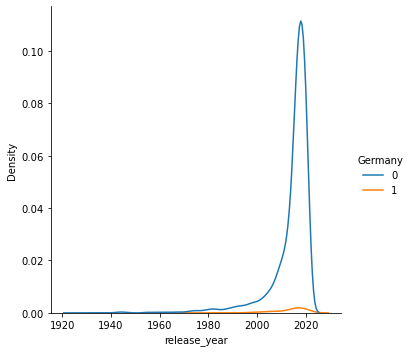

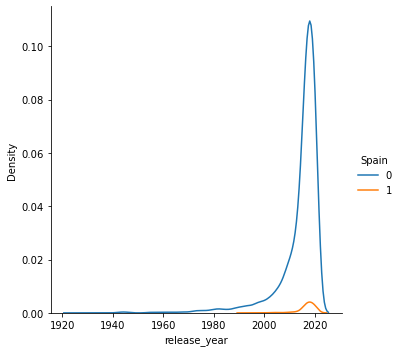

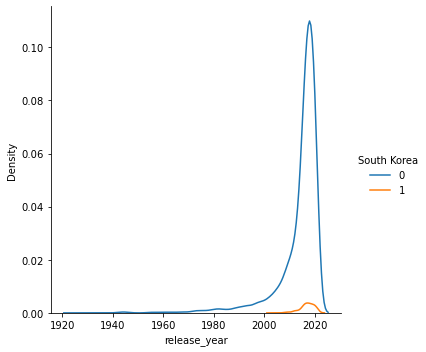

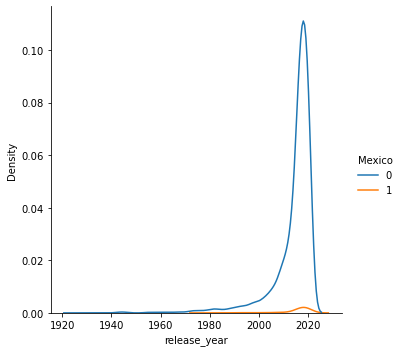

In [45]:
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        sns.displot(data=df_origin_more_countries, x="release_year", hue=country, kind="kde")
        
plt.show()

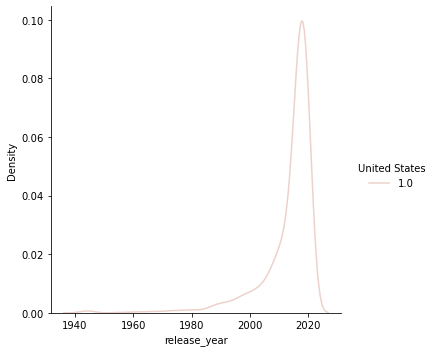

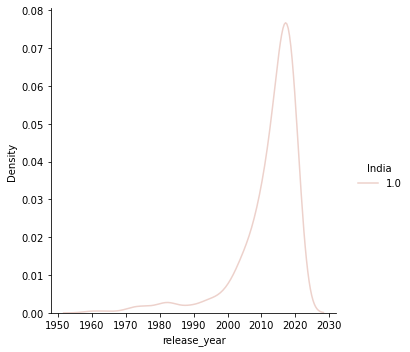

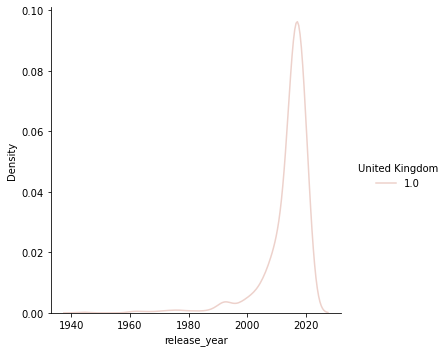

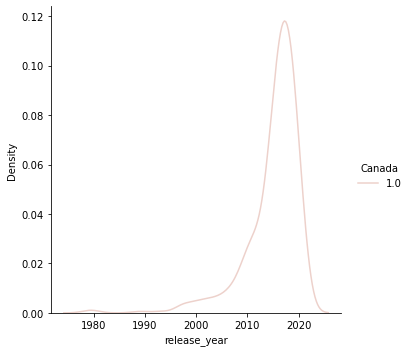

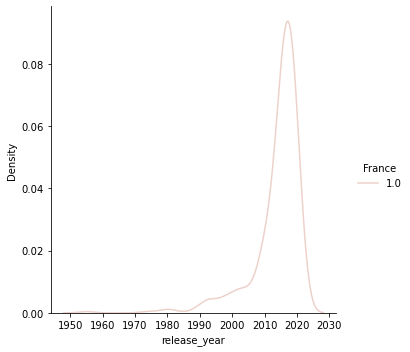

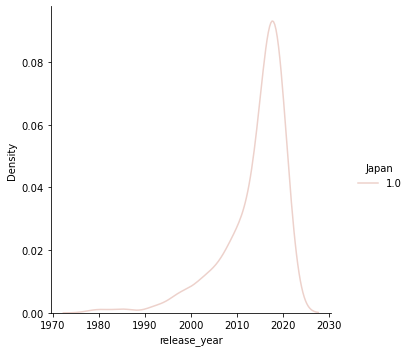

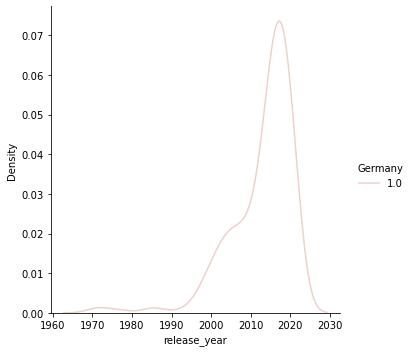

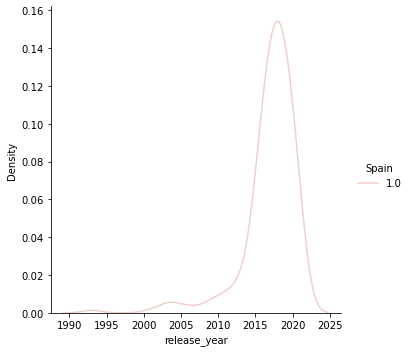

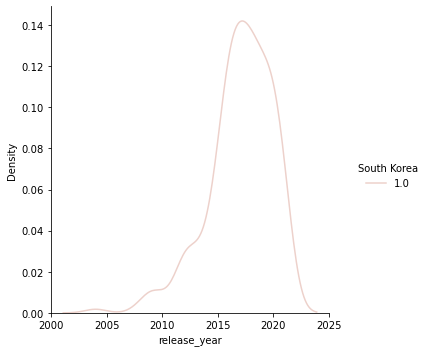

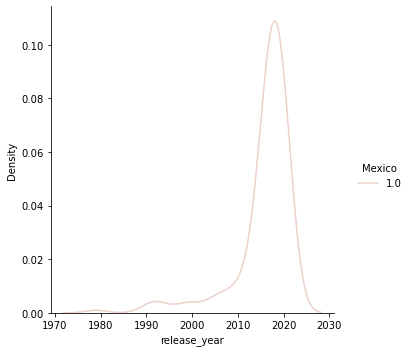

In [52]:
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        sns.displot(data=df_origin_more_countries, x="release_year", hue=country, kind="kde")
        
plt.show()

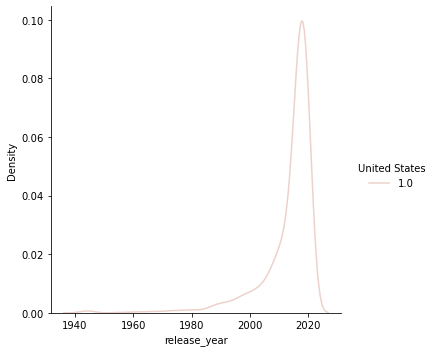

In [51]:
sns.displot(data=df_origin_more_countries, x="release_year", hue="United States", kind="kde")
plt.show()

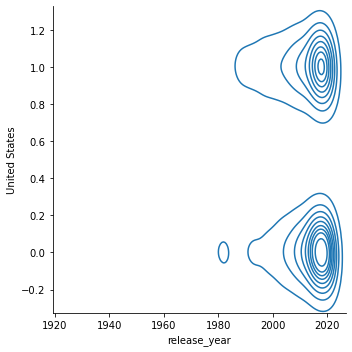

In [46]:
sns.displot(data=df_origin_more_countries, x="release_year", y="United States", kind="kde")
plt.show()

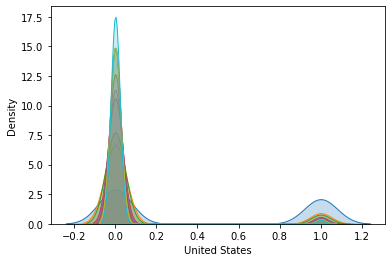

In [40]:
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        sns.kdeplot(df_origin_more_countries[country], shade=True)
        
plt.show()

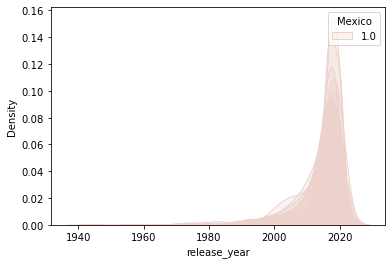

In [55]:
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        sns.kdeplot(data=df_origin_more_countries, x="release_year", hue=country, shade=True)
        
plt.show()

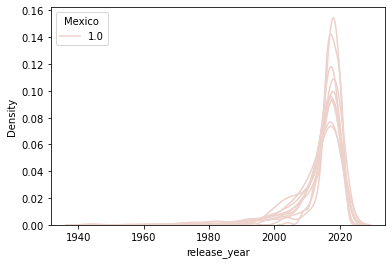

In [56]:
for country in countries_light.index:
    if country != None and country != np.nan and len(country) > 0:
        sns.kdeplot(data=df_origin_more_countries, x="release_year", hue=country)
        
plt.show()

In [ ]:
for colname in countries_light_transpose_light_2.columns:
    if colname != "idx_annee":
        sns.kdeplot(df_origin_more_countries[colname], shade=True)
plt.show()

## 11. Distribution de la durée des films disponibles sur Netflix

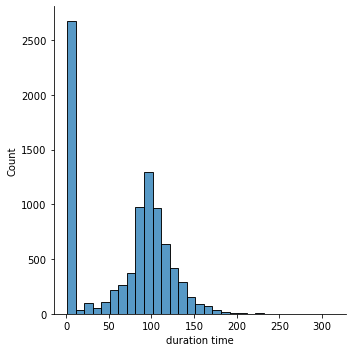

In [168]:
sns.displot(df, x="duration time")

## 12. Tracer un graphique représentant le nombre de séries par modalité de nombre de saisons